# Setup

In [1]:
%matplotlib inline

In [2]:
import phoebe
from phoebe import u,c

import numpy as np
import matplotlib.pyplot as plt

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
logger = phoebe.logger(clevel='WARNING')

In [4]:
b = phoebe.default_binary()

# Atmospheres

Let's start by adding a dataset which probes only the secondary eclipse (as eclipses are where we will see the most dramatic deviations).  We'll specify the passband of the observation to be Johnson:V.

In [5]:
b.add_dataset('lc', times=np.linspace(0.3,0.7,101), dataset='lcV',passband='Johnson:V')

<ParameterSet: 15 parameters | contexts: compute, dataset>

To isolate only the effect of changing the atmosphere, we will temporarily turn off limb-darkening and gravity brightening. We can do this simultaneously for both stars using set_value_all.  Note that upon changing the limb-darkening function, PHOEBE might complain that the limb-darkening coefficients are not valid - this isn't a problem, it's just PHOEBE running checks before we've managed to set the coefficients.

In [6]:
b.set_value_all('ld_func','linear')
b.set_value_all('ld_coeffs',[0.])

Sat, 09 Jun 2018 12:53 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'
Sat, 09 Jun 2018 12:53 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'
Sat, 09 Jun 2018 12:53 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'
Sat, 09 Jun 2018 12:53 PARAMETERS   WARNING ld_coeffs='[0.5 0.5]' inconsistent with ld_func='linear'


In order to really see the differences between using model atmospheres and black bodies, we need to make the two starts different (in this case, we will change only the temperature of the secondary star) and then compute light curves using the two different atmosphere options.  Let's start with the default Castelli & Kurucz (2004) aka 'ck2004' atmospheres.

In [7]:
b['teff@secondary']=4000*u.K
b.run_compute(model='ck2004')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Now let's switch to black body atmospheres and recompute

In [8]:
b.set_value_all('atm','blackbody')
b.run_compute(model='blackbody')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Now, let's plot the two eclipses to see the differences.  Note that because the fluxes are normalised for the primary star (the only star visible during secondary eclipse), the eclipse bottoms are the same while the out of eclipse values are very different.

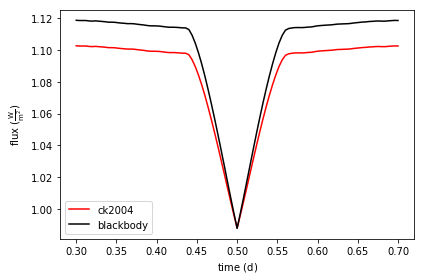

In [9]:
axs, artists = b.plot(model='ck2004',color='r',label='ck2004')
axs, artists = b.plot(model='blackbody',color='k',label='blackbody')
plt.legend()

# Limb-darkening

Let's investigate different limb-darkening parameterisations using binary we've just created. First, we need to turn the atmospheres back to ck2004 (otherwise PHOEBE's native 'interp' limb-darkening won't be available)

In [10]:
b.set_value_all('atm','ck2004')

We are going to compare the results derived using PHOEBE's interpolated limb-darkening to those derived using a couple of different limb-darkening parameterisations.  Let's start with 'interp'

In [11]:
b.set_value_all('ld_func','interp')
b.run_compute(model='interp')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

To compare with other parameterisations, we need to find the corresponding values in a table.  The values for many passbands calculated by Claret & Bloemen (2011) are available via Vizier [here](http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A+A/529/A75) (be careful to choose the right filter - Johnson V not Strömgren v).

In [12]:
b.set_value_all('ld_func','linear')
b.set_value('ld_coeffs@primary',[0.6])
b.set_value('ld_coeffs@secondary',[0.7])
b.run_compute(model='linear')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

In [13]:
b.set_value_all('ld_func','quadratic')
b.set_value('ld_coeffs@primary',[0.4,0.3])
b.set_value('ld_coeffs@secondary',[0.6,0.15])
b.run_compute(model='quadratic')

Sat, 09 Jun 2018 12:54 PARAMETERS   WARNING ld_coeffs='[0.6]' inconsistent with ld_func='quadratic'
Sat, 09 Jun 2018 12:54 PARAMETERS   WARNING ld_coeffs='[0.6]' inconsistent with ld_func='quadratic'
Sat, 09 Jun 2018 12:54 PARAMETERS   WARNING ld_coeffs='[0.7]' inconsistent with ld_func='quadratic'


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Again, let's plot everything to see the differences.  We can include the eclipse calculated in the first part as an example of no limb-darkening too.

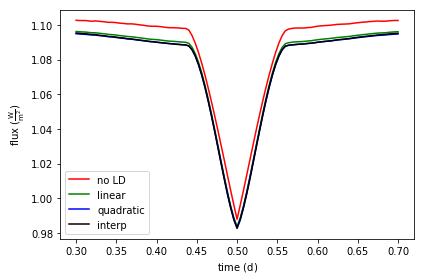

In [14]:
axs, artists = b.plot(model='ck2004',color='r', label='no LD')
axs, artists = b.plot(model='linear',color='g', label='linear')
axs, artists = b.plot(model='quadratic',color='b', label='quadratic')
axs, artists = b.plot(model='interp',color='k', label='interp')
plt.legend()

Clearly, in this case, the linear parameterisation deviates from the curves produced using 'interp' and the quadratic parameterisation (which agree reasonably well), while the curve which ignores limb-darkening is some way off!

# Reflection or Irradiation

Let's start by going back to interpolated limb-darkening.  Also, let's delete our previous data set (because we are now interested in the whole light curve) and add a new one covering the full period.

In [15]:
b.set_value_all('ld_func','interp')
b.remove_dataset('lcV')
b.add_dataset('lc', times=np.linspace(0.0,1.0,101), dataset='lcV',passband='Johnson:V')

<ParameterSet: 15 parameters | contexts: compute, dataset>

Now we'll turn on irradiation by setting the method in compute

In [16]:
b['irrad_method@compute']='wilson'

Now we can set the fraction of incident bolometric flux that will be used for heating (this parameter is exposed even if the irrad_method is set to none, but in that case it is ignored).  This is per-component so we need to set it for each star - and it must be less than unity for each component as this would not be physical.

In [17]:
b['irrad_frac_refl_bol@primary']=0.3
b['irrad_frac_refl_bol@secondary']=0.7

This parameter constrains another which is the fraction of incident bolometric flux which is lost/ignored.  The sum must be equal to unity (i.e. 100% of incident bolometric flux should be used for heating or ignored - no more, no less).

In [18]:
b['irrad_frac_lost_bol@primary@constraint']

<ConstraintParameter: {irrad_frac_lost_bol@primary@component} = 1.000000 - {irrad_frac_refl_bol@primary@component} => 0.7>

In [19]:
b.run_compute(model='wilson')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

Now, let's turn off irradiation and re-calculate the light curve.

In [20]:
b['irrad_method@compute']='none'
b.run_compute(model='noIrrad')

<ParameterSet: 2 parameters | qualifiers: fluxes, times>

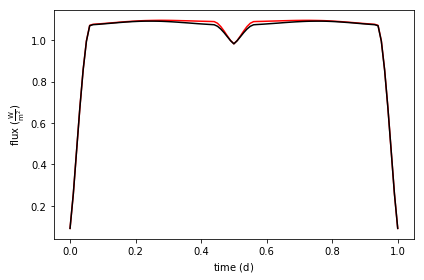

In [21]:
axs, artists = b.plot(model='wilson',color='r')
axs, artists = b.plot(model='noIrrad',color='k')

There is a difference (particularly around secondary eclipse where we are looking at the heated face of the secondary), even with two "cool" stars.  The effect is much stronger in systems with large temperature differences, so let's make one by changing the primary to a (rather massive) white dwarf.

In [22]:
b['teff@primary']=30000*u.K
b['rpole@primary']=0.05*u.solRad
b['gravb_bol@primary']=1.0

Sat, 09 Jun 2018 12:55 PARAMETERS   WARNING 'primary' probably has a radiative atm (teff=30000K>8000K), for which gravb_bol=1.00 might be a better approx than gravb_bol=0.32
Sat, 09 Jun 2018 12:55 PARAMETERS   WARNING 'primary' probably has a radiative atm (teff=30000K>8000K), for which gravb_bol=1.00 might be a better approx than gravb_bol=0.32
Sat, 09 Jun 2018 12:55 PARAMETERS   WARNING 'primary' probably has a radiative atm (teff=30000K>8000K), for which gravb_bol=1.00 might be a better approx than gravb_bol=0.32


ck2004 atmospheres are almost certainly invalid for such a white dwarf, so we should probably change to a blackbody and set the limb-darkening.  We can use the tables for white dwarfs from [Gianninas et al. (2013, ApJ, 766,3)](http://vizier.cfa.harvard.edu/viz-bin/VizieR-3?-source=J/ApJ/766/3/limbdark).

In [23]:
b['atm@primary']='blackbody'
b['ld_func@primary']='quadratic'
b['ld_coeffs@primary']=[0.06,0.30]

Sat, 09 Jun 2018 12:55 PARAMETERS   WARNING ld_func='interp' only supported by atm='ck2004'


Calculate the curves with and without irradiation

In [24]:
b['irrad_method@compute']='wilson'
b.run_compute(model='wilson')
b['irrad_method@compute']='none'
b.run_compute(model='noIrrad')

Sat, 09 Jun 2018 12:55 BUNDLE       WARNING overwriting model: wilson
Sat, 09 Jun 2018 12:55 BUNDLE       WARNING overwriting model: noIrrad


<ParameterSet: 2 parameters | qualifiers: fluxes, times>

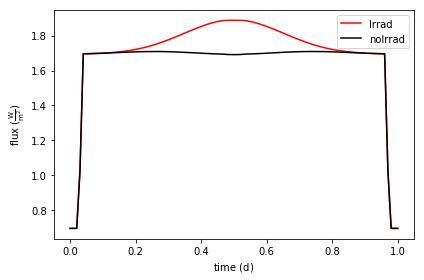

In [25]:
axs, artists = b.plot(model='wilson',color='r',label='Irrad')
axs, artists = b.plot(model='noIrrad',color='k',label='noIrrad')
plt.legend()

Now the difference is much more pronounced - in some (real life) extreme cases the amplitude of this effect can exceed one magnitude!

# Exercise

Try adding a dataset in a different passband to see how the difference between model atmospheres and black bodies is wavelength dependent

For the next part, you might find the following convenience function useful.  It returns log g (in cgs units) for a given stellar and mass (both in solar units).  Note that the actual (mean) value for the stars in our 1 day period binary are likely to be a little larger, but this function should serve as a reasonable approximation for looking up tabulated limb-darkening parameters.

In [26]:
def logg(R,M=1.):
        g=c.G*M*u.Msun/((R*u.Rsun)**2)
        logg=np.log10(g.to(u.cm/u.s**2).value)
        return logg

For example, to find the log g of a 1.5 solar mass star with a radius of two solar radii.

In [27]:
logg(2,1.5)

4.012098895030852

Vary all the stellar parameters - temperature, radius, metallicity (the 'abun' parameter) and mass (it may be convenient to flip a constraint in order to vary the masses) - to explore the parameter space covered by the ck2004 atmosphere models (and interpolated limb-darkening).  You may also wish to change the gravity brightening/darkening coefficients depending on your particular parameters - you can use those suggested by PHOEBE or the tabulated values from, for example, [Claret & Bloemen (2011)](http://vizier.cfa.harvard.edu/viz-bin/VizieR?-source=J/A+A/529/A75) again.  If you compare your lightcurves using 'interp' limb-darkening to lightcurves using other parameterisation, remembers to update the coefficients every time you change the stellar parameters!